In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support, roc_curve, roc_auc_score
from bayes_opt import BayesianOptimization
import time
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
import ssl
import warnings
ssl._create_default_https_context = ssl._create_unverified_context
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/shadiajaafar1/ParcialML2/main/dataset_final%20(1).csv')
df.head()

,isFraud,TransactionDT,TransactionAmt,card2,card3,C3,C5,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_credit,D3
0,0,86400,68.5,361.0,150.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,13.0
1,0,86401,29.0,404.0,150.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,8.0
2,0,86469,59.0,490.0,150.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0
3,0,86499,50.0,567.0,150.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,86506,50.0,514.0,150.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,8.0


In [4]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

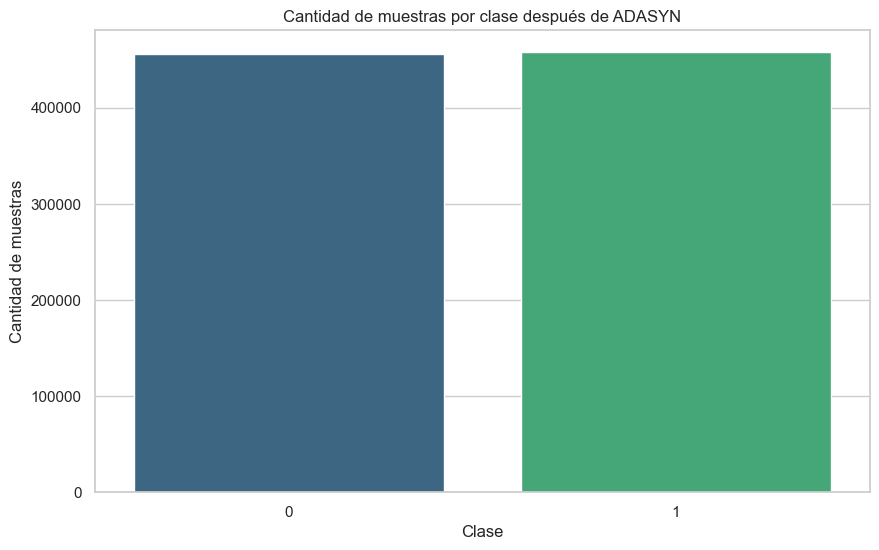

In [7]:
y_resampled = pd.Series(y_resampled)
class_counts_resampled = y_resampled.value_counts()
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6)) 
sns.barplot(x=class_counts_resampled.index, y=class_counts_resampled.values, palette="viridis")

plt.title('Cantidad de muestras por clase después de ADASYN')
plt.xlabel('Clase')
plt.ylabel('Cantidad de muestras')
plt.show()


In [8]:
print("Distribución de clases original:", np.bincount(y_train))
print("Distribución de clases después de ADASYN:", np.bincount(y_resampled))


Distribución de clases original: [456011  16421]
Distribución de clases después de ADASYN: [456011 457746]


In [9]:
pipelines = {
    'knn': Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]),
}

param_grid = {
    'knn': {'knn__n_neighbors': [3, 5, 7]},
}

In [10]:
results = []
start_time = time.time()

for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:,1]
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    results.append({
        'Model': name,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'AUC': roc_auc,
        'FPR': fpr,
        'TPR': tpr
    })
print('pase')
def optimize_bayesian(model, param_ranges):
    pbounds = {k: v for k, v in param_ranges.items()}
    
    def bo_func(**params):
        for param in params:
            if type(params[param]) is float and int(params[param]) == params[param]:
                params[param] = int(params[param])
        model.set_params(**params)
        scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=5)
        return np.mean(scores)

    optimizer = BayesianOptimization(
        f=bo_func,
        pbounds=pbounds,
        random_state=1,
        verbose=2
    )
    optimizer.maximize(init_points=5, n_iter=10)
    return optimizer.max['params']

print('pase')

for result in results:
    model = pipelines[result['Model']].named_steps[result['Model']]
    param_ranges = {
        key.replace(f"{result['Model']}__", ''): (value[0], value[-1])
        for key, value in param_grid[result['Model']].items()
    }
    best_params = optimize_bayesian(model, param_ranges)
    model.set_params(**best_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    result.update({
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'AUC': roc_auc,
        'FPR': fpr,
        'TPR': tpr
    })

print('termine')

end_time = time.time() 
total_time = end_time - start_time

metrics_df = pd.DataFrame(results)
print(metrics_df[['Model', 'Precision', 'Recall', 'F1 Score', 'AUC']])

plt.figure(figsize=(10, 8))
for i in results:
    plt.plot(i['FPR'], i['TPR'], label=f"{i['Model']} (AUC = {i['AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves after Bayesian Optimization')
plt.legend(loc="lower right")
plt.show()

print('Tiempo total de ejecución: ', total_time)
